# Import module

The link to get [ImageAnalysis3](https://github.com/zhengpuas47/ImageAnalysis3) 

Or from the Zhuang lab archived [source_tools](https://github.com/ZhuangLab/Chromatin_Analysis_2020_cell/tree/master/sequential_tracing/source)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import anndata
import scanpy as sc
import os

import matplotlib.pyplot as plt

## ImageAnalysis3 and basic modules

In [2]:
# Pu's ImageAnalysis3
%run "C:\Users\shiwei\Documents\ImageAnalysis3\required_files\Startup_py3.py"
sys.path.append(r"C:\Users\shiwei\Documents")

import ImageAnalysis3 as ia
%matplotlib inline

from ImageAnalysis3 import *
print(os.getpid())

import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast


46388


## Chromatin_analysis_tools etc

See **functions** in the repository for [AnalysisTool_Chromatin](../../README.md)

In [3]:
# Chromatin_analysis_tools (ATC)
# Get path for the py containing functions
import os
import sys
import importlib
module_path =r'C:\Users\shiwei\Documents\AnalysisTool_Chromatin'
if module_path not in sys.path:
    sys.path.append(module_path)
    
# import relevant modules
import gene_selection 
importlib.reload(gene_selection)
import gene_to_loci
importlib.reload(gene_to_loci)
import gene_activity
importlib.reload(gene_activity)
import loci_1d_features
importlib.reload(loci_1d_features)  

import atac_to_loci
importlib.reload(atac_to_loci)

<module 'atac_to_loci' from 'C:\\Users\\shiwei\\Documents\\AnalysisTool_Chromatin\\atac_to_loci.py'>

# Define folders

In [4]:
# main folder for postanalysis
postanalysis_folder = r'L:\Shiwei\postanalysis_2024\v0'
# input files for postanalysis
input_folder = os.path.join(postanalysis_folder, 'resources_from_preprocess')

# output file to be generated
output_main_folder = os.path.join(postanalysis_folder, 'method_overview')

output_analysis_folder = os.path.join(output_main_folder, 'analysis')
output_figure_folder = os.path.join(output_main_folder, 'figures')

# make new folder if needed
make_output_folder = True

if make_output_folder and not os.path.exists(output_analysis_folder):
    os.makedirs(output_analysis_folder)
    print(f'Generating analysis folder: {output_analysis_folder}.')
elif os.path.exists(output_analysis_folder):
    print(f'Use existing analysis folder: {output_analysis_folder}.')
    
if make_output_folder and not os.path.exists(output_figure_folder):
    os.makedirs(output_figure_folder)
    print(f'Generating figure folder: {output_figure_folder}.')
elif os.path.exists(output_figure_folder):
    print(f'Use existing figure folder: {output_figure_folder}.')

Use existing analysis folder: L:\Shiwei\postanalysis_2024\v0\method_overview\analysis.
Use existing figure folder: L:\Shiwei\postanalysis_2024\v0\method_overview\figures.


# Plotting parameters

In [5]:
%matplotlib inline
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
import matplotlib.pyplot as plt
plt.rc('font', family='serif')
plt.rc('font', serif='Arial')

from ImageAnalysis3.figure_tools import _double_col_width, _single_col_width, _font_size, _ticklabel_size,_ticklabel_width

import seaborn as sns
sns.set_context("paper", rc={"font.size":_font_size,"axes.titlesize":_font_size+1,"axes.labelsize":_font_size})  

In [6]:
# Other required plotting parameters
_dpi = 300
_font_size = 7
_page_width = 5.5

sc.settings.n_jobs = 24
sc.settings.set_figure_params(dpi=_dpi/2, dpi_save=_dpi, frameon=False, 
                              figsize=(_page_width/2, _page_width/2), fontsize=_font_size, facecolor='white', transparent=True)
sc.settings.figdir = output_figure_folder

# Load data relevant information

## load and format codebook

[merged codebook](../resources/merged_codebook.csv) as in the repository (merged for all DNA-MERFISH libraries)

In [7]:
# Load codebook 
codebook_fname = os.path.join(input_folder,'merged_codebook.csv')
codebook_df = pd.read_csv (codebook_fname, index_col=0)

# sort df by chr and chr_order
codebook_df = loci_1d_features.sort_loci_df_by_chr_order (codebook_df)
codebook_df.head()

,name,id,NDB_784,NDB_755,NDB_826,NDB_713,NDB_865,NDB_725,NDB_817,NDB_710,...,NDB_479,NDB_562,NDB_608,NDB_460,NDB_563,NDB_592,NDB_368,NDB_436,NDB_629,NDB_604
0,1:3742742-3759944,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1:6245958-6258969,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1:8740008-8759916,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1016,1:9627926-9637875,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1017,1:9799472-9811359,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [9]:
# Format the chr loci name by 
# 1. changing loci name format
# 2. extract relevant information such as id, chr, chr_order, and library etc
from gene_to_loci import loci_pos_format
loci_name_list = list(map(loci_pos_format, codebook_df['name'].tolist()))
loci_name_arr = np.array(loci_name_list)

# convert to a new dataframe and set loci name as index
codebook_df = codebook_df[['name','id','chr','chr_order','library']]
codebook_df['loci_name'] = list(loci_name_arr[:,0])
codebook_df = codebook_df.set_index ('loci_name')

codebook_df.head()

,name,id,chr,chr_order,library
loci_name,,,,,
chr1_3742742_3759944,1:3742742-3759944,1,1,0.0,CTP11
chr1_6245958_6258969,1:6245958-6258969,2,1,1.0,CTP11
chr1_8740008_8759916,1:8740008-8759916,3,1,2.0,CTP11
chr1_9627926_9637875,1:9627926-9637875,1,1,3.0,CTP13
chr1_9799472_9811359,1:9799472-9811359,2,1,4.0,CTP13


# Load Chr2Zxys dict

**subclass_2_chr2Zxys.pkl** can be generated using jupyter notebook as below:

[preprocess/2_dna_merfish/scripts/2_spot_pick/4_summarize_jie_to_dict](../../../preprocess/2_dna_merfish/scripts/2_spot_pick/4_summarize_jie_to_dict.ipynb)

In [8]:
subclass_2_chr2Zxys_filename = os.path.join(input_folder, 'subclass_2_chr2Zxys.pkl')
subclass_2_chr2ZxysList = pickle.load(open(subclass_2_chr2Zxys_filename, 'rb'))

In [9]:
subclass_2_chr2ZxysList.keys()

dict_keys(['Oligo', 'L5 IT', 'Micro', 'Peri', 'Endo', 'Astro', 'OPC', 'L6 CT', 'L5 ET', 'L5/6 NP', 'Pvalb', 'L6 IT', 'Lamp5', 'L6b', 'Sst', 'SMC', 'L4/5 IT', 'L2/3 IT', 'Vip', 'Sncg', 'VLMC'])

# Select cells to plot

## load additional functions

In [10]:
from ImageAnalysis3 import _distance_zxy
from ImageAnalysis3.figure_tools.color import transparent_gradient
from ImageAnalysis3.figure_tools import _dpi,_single_col_width,_double_col_width,_single_row_height,_ref_bar_length, _ticklabel_size,_ticklabel_width,_font_size
#_color_dict={
    #'A':[1.,0.,0.],
    #'B':[0.,0.,1.],
#}
# 3d plotting
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
from mpl_toolkits.mplot3d import Axes3D
from skimage.measure import marching_cubes # 3d cloud calculation

In [11]:
from ImageAnalysis3.figure_tools.plot_decode import Centering_Chr2ZxysListDict, summarize_chr2Zxys
from ImageAnalysis3.structure_tools.distance import sort_chr
# use new version of sort chr to assign chrX as chr20 so the chr_colorbar would look correct below
help(loci_1d_features.sort_mouse_chr)

Help on function sort_mouse_chr in module loci_1d_features:

sort_mouse_chr(_chr)
    # Use for sorting chromosome by number (from PZ)



In [12]:
genome_cmap = cm.Spectral.copy()

In [15]:
plt.style.use('dark_background')

## plot Oligo

In [13]:
sel_subclass = 'Oligo'
sel_cell_indices = []
for _cell_index, _chr2Zxys in enumerate(subclass_2_chr2ZxysList[sel_subclass]):
    # cells with 20 chr
    if len(_chr2Zxys) >= 20:
        sel_cell_indices.append(_cell_index)
        
print(len(sel_cell_indices))

879


### all chromosomes

0.0 0.5235987755982988


meta NOT subset; don't know how to subset; dropped
C:\Users\shiwei\AppData\Local\Temp\3\ipykernel_46388\706477065.py:139: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


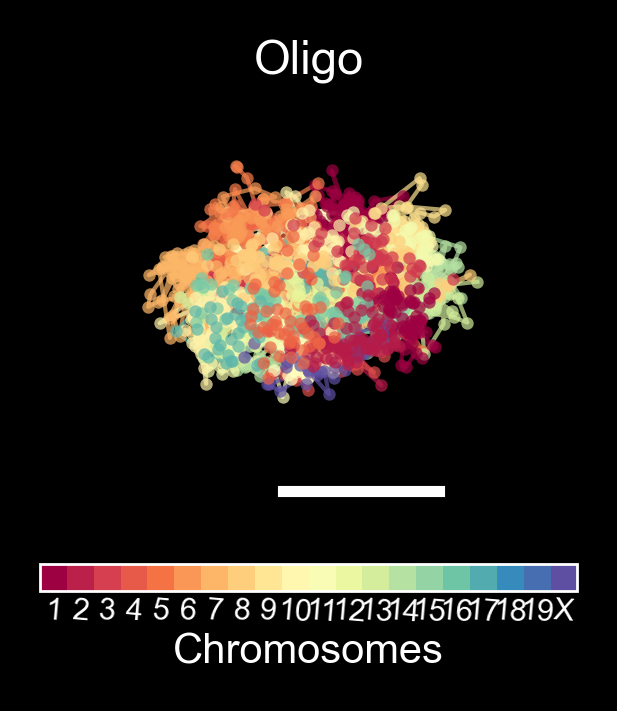

In [16]:
%matplotlib inline
#%matplotlib notebook
# select one cell from the candidate indices
_idx_to_plot = 8
_sel_cell_ind = sel_cell_indices[_idx_to_plot]
_dict = subclass_2_chr2ZxysList[sel_subclass][_sel_cell_ind]



from matplotlib.colors import BoundaryNorm
from matplotlib import animation
plot_animation = False
hide_axes = True
add_refBar = True
refBar_len = 5 # in um
angle = 3

_centered_dict = Centering_Chr2ZxysListDict(_dict)
_chr_2_color = {_key:genome_cmap((sort_chr(_key)-1)/22) for _key in sorted(_dict.keys(), key = lambda v:sort_chr(v))}

plot_radius = 4

marker_size = 5
marker_alpha = 0.7

depthshade=False
fig = plt.figure(figsize=(_page_width/3.5, _page_width/3.5), dpi=200)

ax3d = fig.add_subplot(111, projection='3d', azim=0, elev=30)
#ax3d.set_facecolor(background_color)
fig.subplots_adjust(left=0.05, right=0.95, bottom=0, top=0.9)
# turn off axes if needed
if hide_axes:
    ax3d.set_axis_off()
# turn off grid if needed
ax3d.grid(False)
ax3d.xaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
ax3d.yaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
ax3d.zaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
# scatter plot
for _chr in sorted(_centered_dict.keys(), key = lambda v:sort_chr(v)):
    _zxys_list = _centered_dict[_chr]
    for _zxys in _zxys_list:
        #print(_chr)
        _valid_inds = (np.isnan(_zxys).sum(1) == 0)
        _sc = ax3d.scatter(_zxys[_valid_inds,1], _zxys[_valid_inds,2], _zxys[_valid_inds,0],
                           color=_chr_2_color[_chr], 
                           s=marker_size, depthshade=depthshade, 
                           alpha=marker_alpha,
                           #edgecolors=_edge_colors, 
                           linewidth=0, label=f"{_chr}")
        _ln = ax3d.plot(_zxys[_valid_inds,1], _zxys[_valid_inds,2], _zxys[_valid_inds,0],
                        color=_chr_2_color[_chr], linewidth=0.75, alpha=marker_alpha)
ax3d.tick_params('both', labelsize=_font_size, 
                    width=0, length=0,
                    pad=0, labelleft=True, labelbottom=True) # remove bottom ticklabels for ax1
[i[1].set_linewidth(0.5) for i in ax3d.spines.items()]

# axes limits
ax3d.axes.set_xlim3d(left=-plot_radius, right=plot_radius) 
ax3d.axes.set_ylim3d(bottom=-plot_radius, top=plot_radius) 
ax3d.axes.set_zlim3d(bottom=-plot_radius, top=plot_radius) 
# axes ticks
ax3d.set_xticks(np.arange(-plot_radius,plot_radius+1, 2))
ax3d.set_yticks(np.arange(-plot_radius,plot_radius+1, 2))
ax3d.set_zticks(np.arange(-plot_radius,plot_radius+1, 2))
# axes labels
ax3d.set_xlabel(f"X (\u03BCm)", fontsize=_font_size, labelpad=0)
ax3d.set_ylabel(f"Y (\u03BCm)", fontsize=_font_size, labelpad=0)
ax3d.set_zlabel(f"Z (\u03BCm)", fontsize=_font_size, labelpad=0)
# title
ax3d.set_title(f"{sel_subclass}" ,fontsize=_font_size+1, pad=0)
# colorbar
bounds = [loci_1d_features.sort_mouse_chr(_chr) for _chr in _centered_dict.keys()]
bounds.append(np.max(bounds)+1)
bounds = np.sort(bounds)
norm = BoundaryNorm(bounds, genome_cmap.N)
cbar_shrink = 0.95
m = cm.ScalarMappable(cmap=genome_cmap, norm=norm)
cbar = plt.colorbar(m, ax=ax3d, orientation='horizontal', pad=0.1, 
                    ticks=bounds[:-1]+0.5,
                    boundaries=bounds,
                    shrink=cbar_shrink)
cbar.set_label('Chromosomes', fontsize=_font_size, labelpad=1,)
cbar.ax.set_xticklabels(np.array(sorted(_dict.keys(), key = lambda v:sort_chr(v))), fontsize=_font_size)

cbar.ax.tick_params('both', which='both',labelsize=_font_size-2, 
                    width=0.0, length=0.0,rotation =-5,
                    pad=1, labelleft=False, labelbottom=True) # remove bottom ticklabels for ax1
# vertical alignment of xtick labels
va = [-0.01 if i%2 else 0 for i in range(len(cbar.ax.get_xticklabels()))]
for t, y in zip(cbar.ax.get_xticklabels(), va):
    t.set_y(y)

[i[1].set_linewidth(0.5) for i in cbar.ax.spines.items()]



# save
fig_basename = f"decode3D_type_{sel_subclass.replace(' ', '_').replace(r'/', '-')}_cell_{_sel_cell_ind}"
# animation
if plot_animation:
    def rotate3D(angle):
         ax3d.view_init(azim=angle)
    ani = animation.FuncAnimation(fig, rotate3D, frames=np.arange(0, 360*2, angle), interval=50)
    ani.save(os.path.join(output_figure_folder, fig_basename+".gif"), 
             writer=animation.PillowWriter(fps=30), )
else:
    # add ref
    if add_refBar:
        # convert to degree, which matches numpy cos and sin
        _azim = (ax3d.azim%360) / 180 * np.pi 
        _elev = (ax3d.elev%360) / 180 * np.pi
        print(_azim, _elev)
        # start coordinate for colorbar
        _bar_starts = np.array([-2.5, # z, draw to the bottom
                                -np.sin(_azim), # x, y, extension goes through 0,0
                                np.cos(_azim), 
                                ]) * plot_radius
        # ongoing vector for colorbar:
        _bar_vector = np.array([0,
                                np.sin(_azim),
                                -np.cos(_azim),
                                ]) * refBar_len
        # therefore, end of colorbar
        _bar_ends = _bar_starts + _bar_vector
        #print(_bar_starts, _bar_ends)
        _ref_line = ax3d.plot([_bar_starts[1], _bar_ends[1]],
                              [_bar_starts[2], _bar_ends[2]], 
                              [_bar_starts[0], _bar_ends[0]], 
                              color=tuple([1-_c for _c in ax3d.get_facecolor()[:3]]+[1]), 
                              linewidth=2)

    # save pdf and png
    fig.savefig(os.path.join(output_figure_folder, fig_basename+".pdf"),
                transparent=False, bbox_inches='tight', pad_inches=.05, dpi=300)
    fig.savefig(os.path.join(output_figure_folder, fig_basename+".png"),
                transparent=False, bbox_inches='tight', pad_inches=.05, dpi=300)
fig.show()

### selected chromosomes

0.0 0.5235987755982988


C:\Users\shiwei\AppData\Local\Temp\3\ipykernel_46388\4003892278.py:149: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


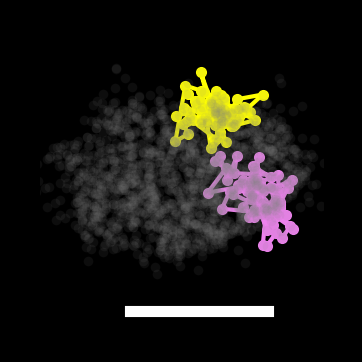

In [17]:
_sel_chr = '1'

if len(_dict[_sel_chr]) == 1:
    _homolog_2_color = {0:genome_cmap(1/2)}
else:
    #_homolog_2_color = {_i:genome_cmap((_i) / (len(_dict[_sel_chr])-1) ) 
                        #for _i in range(len(_dict[_sel_chr]))}
    _homolog_2_color = {0:'violet', 1:'yellow'}

    
from matplotlib.colors import BoundaryNorm
from matplotlib import animation
plot_animation = False
hide_axes = True
add_refBar = True
refBar_len = 5 # in um
angle = 3

add_cbar = False

_centered_dict = Centering_Chr2ZxysListDict(_dict)

plot_radius = 3

marker_size = 4
marker_alpha = 1

depthshade=False
fig = plt.figure(figsize=(_page_width/7, _page_width/7), dpi=200)

ax3d = fig.add_subplot(111, projection='3d', azim=0, elev=30)
#ax3d.set_facecolor(background_color)
fig.subplots_adjust(left=0.05, right=0.95, bottom=0, top=0.9)
# turn off axes if needed
if hide_axes:
    ax3d.set_axis_off()
# turn off grid if needed
ax3d.grid(False)
ax3d.xaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
ax3d.yaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
ax3d.zaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
# all spots as ref
merged_zxys, merged_rids = summarize_chr2Zxys(_centered_dict, codebook_df, keep_valid=True)
merged_zxys = merged_zxys
_valid_inds = (np.isnan(merged_zxys).sum(1) == 0)
_sc = ax3d.scatter(merged_zxys[_valid_inds,1], merged_zxys[_valid_inds,2], merged_zxys[_valid_inds,0],
                   color='Grey', 
                   s=marker_size-1, depthshade=depthshade, 
                   alpha=0.1,
                   linewidth=0, label=f"genome")

# scatter plot
_zxys_list = _centered_dict[_sel_chr]
for _ihomo, _zxys in enumerate(_zxys_list):
    #print(_chr)
    _valid_inds = (np.isnan(_zxys).sum(1) == 0)
    _sc = ax3d.scatter(_zxys[_valid_inds,1], _zxys[_valid_inds,2], _zxys[_valid_inds,0],
                       color=_homolog_2_color[_ihomo], 
                       s=marker_size, depthshade=depthshade, 
                       alpha=marker_alpha,
                       #edgecolors=_edge_colors, 
                       linewidth=0, label=f"h_{_ihomo}")
    _ln = ax3d.plot(_zxys[_valid_inds,1], _zxys[_valid_inds,2], _zxys[_valid_inds,0],
                    color=_homolog_2_color[_ihomo], linewidth=0.75, alpha=marker_alpha)

ax3d.tick_params('both', labelsize=_font_size-0.5, 
                    width=_ticklabel_width, length=_ticklabel_size,
                    pad=0, labelleft=True, labelbottom=True) # remove bottom ticklabels for ax1
[i[1].set_linewidth(0.5) for i in ax3d.spines.items()]

# axes limits
ax3d.axes.set_xlim3d(left=-plot_radius, right=plot_radius) 
ax3d.axes.set_ylim3d(bottom=-plot_radius, top=plot_radius) 
ax3d.axes.set_zlim3d(bottom=-plot_radius, top=plot_radius) 
# axes ticks
ax3d.set_xticks(np.arange(-plot_radius,plot_radius+1, 2))
ax3d.set_yticks(np.arange(-plot_radius,plot_radius+1, 2))
ax3d.set_zticks(np.arange(-plot_radius,plot_radius+1, 2))
# axes labels
ax3d.set_xlabel(f"X (\u03BCm)", fontsize=_font_size, labelpad=0)
ax3d.set_ylabel(f"Y (\u03BCm)", fontsize=_font_size, labelpad=0)
ax3d.set_zlabel(f"Z (\u03BCm)", fontsize=_font_size, labelpad=0)
# title
#ax3d.set_title(f"Chr{_sel_chr}" ,fontsize=_font_size+1, pad=0)

if add_cbar:
    # colorbar
    if len(_dict[_sel_chr]) == 1:
        bounds = [-1,0]
    else:
        bounds = list(np.arange(len(_dict[_sel_chr])+1 ))
    #bounds.append(np.max(bounds)+1)
    bounds = np.sort(bounds)
    norm = BoundaryNorm(bounds, genome_cmap.N)
    cbar_shrink = 0.8
    m = cm.ScalarMappable(cmap=genome_cmap, norm=norm)
    cbar = plt.colorbar(m, ax=ax3d, orientation='horizontal', pad=0.1, 
                        ticks=bounds[:-1]+0.5,
                        boundaries=bounds,
                        shrink=cbar_shrink)
    cbar.set_label('Homologs', fontsize=_font_size, labelpad=1,)
    cbar.ax.set_xticklabels(np.arange(len(_dict[_sel_chr])), fontsize=_font_size)
    cbar.ax.tick_params('both', labelsize=_font_size-2.5, 
                        width=_ticklabel_width, length=_ticklabel_size/2,
                        pad=1, labelleft=False, labelbottom=True) # remove bottom ticklabels for ax1
    [i[1].set_linewidth(0.5) for i in cbar.ax.spines.items()]

# save
fig_basename = f"decode3D_type_{sel_subclass.replace(' ', '_').replace(r'/', '-')}_cell_{_sel_cell_ind}_chr_{_sel_chr}"

# animation
if plot_animation:
    def rotate3D(angle):
         ax3d.view_init(azim=angle)
    ani = animation.FuncAnimation(fig, rotate3D, frames=np.arange(0, 360*2, angle), interval=50)
    ani.save(os.path.join(output_figure_folder, fig_basename+".gif"), 
             writer=animation.PillowWriter(fps=30), )
else:
    # add ref
    if add_refBar:
        # convert to degree, which matches numpy cos and sin
        _azim = (ax3d.azim%360) / 180 * np.pi 
        _elev = (ax3d.elev%360) / 180 * np.pi
        print(_azim, _elev)
        # start coordinate for colorbar
        _bar_starts = np.array([-2.5, # z, draw to the bottom
                                -np.sin(_azim), # x, y, extension goes through 0,0
                                np.cos(_azim), 
                                ]) * plot_radius
        # ongoing vector for colorbar:
        _bar_vector = np.array([0,
                                np.sin(_azim),
                                -np.cos(_azim),
                                ]) * refBar_len
        # therefore, end of colorbar
        _bar_ends = _bar_starts + _bar_vector
        #print(_bar_starts, _bar_ends)
        _ref_line = ax3d.plot([_bar_starts[1], _bar_ends[1]],
                              [_bar_starts[2], _bar_ends[2]], 
                              [_bar_starts[0], _bar_ends[0]], 
                              color=tuple([1-_c for _c in ax3d.get_facecolor()[:3]]+[1]), 
                              linewidth=2)

    # save pdf and png
    fig.savefig(os.path.join(output_figure_folder, fig_basename+".pdf"),
                transparent=False, bbox_inches='tight', pad_inches=0.05)
    fig.savefig(os.path.join(output_figure_folder, fig_basename+".png"),
                transparent=False, bbox_inches='tight', pad_inches=0.05)
fig.show()

0.0 0.5235987755982988


C:\Users\shiwei\AppData\Local\Temp\3\ipykernel_46388\2953170993.py:149: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


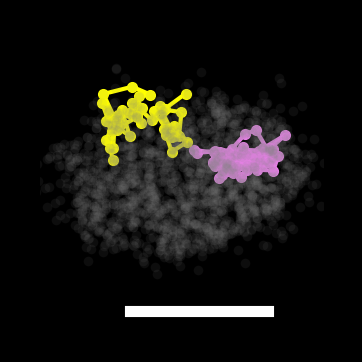

In [18]:
_sel_chr = '7'

if len(_dict[_sel_chr]) == 1:
    _homolog_2_color = {0:genome_cmap(1/2)}
else:
    #_homolog_2_color = {_i:genome_cmap((_i) / (len(_dict[_sel_chr])-1) ) 
                        #for _i in range(len(_dict[_sel_chr]))}
    _homolog_2_color = {0:'violet', 1:'yellow'}

    
from matplotlib.colors import BoundaryNorm
from matplotlib import animation
plot_animation = False
hide_axes = True
add_refBar = True
refBar_len = 5 # in um
angle = 3

add_cbar = False

_centered_dict = Centering_Chr2ZxysListDict(_dict)

plot_radius = 3

marker_size = 4
marker_alpha = 1

depthshade=False
fig = plt.figure(figsize=(_page_width/7, _page_width/7), dpi=200)

ax3d = fig.add_subplot(111, projection='3d', azim=0, elev=30)
#ax3d.set_facecolor(background_color)
fig.subplots_adjust(left=0.05, right=0.95, bottom=0, top=0.9)
# turn off axes if needed
if hide_axes:
    ax3d.set_axis_off()
# turn off grid if needed
ax3d.grid(False)
ax3d.xaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
ax3d.yaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
ax3d.zaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
# all spots as ref
merged_zxys, merged_rids = summarize_chr2Zxys(_centered_dict, codebook_df, keep_valid=True)
merged_zxys = merged_zxys
_valid_inds = (np.isnan(merged_zxys).sum(1) == 0)
_sc = ax3d.scatter(merged_zxys[_valid_inds,1], merged_zxys[_valid_inds,2], merged_zxys[_valid_inds,0],
                   color='Grey', 
                   s=marker_size-1, depthshade=depthshade, 
                   alpha=0.1,
                   linewidth=0, label=f"genome")

# scatter plot
_zxys_list = _centered_dict[_sel_chr]
for _ihomo, _zxys in enumerate(_zxys_list):
    #print(_chr)
    _valid_inds = (np.isnan(_zxys).sum(1) == 0)
    _sc = ax3d.scatter(_zxys[_valid_inds,1], _zxys[_valid_inds,2], _zxys[_valid_inds,0],
                       color=_homolog_2_color[_ihomo], 
                       s=marker_size, depthshade=depthshade, 
                       alpha=marker_alpha,
                       #edgecolors=_edge_colors, 
                       linewidth=0, label=f"h_{_ihomo}")
    _ln = ax3d.plot(_zxys[_valid_inds,1], _zxys[_valid_inds,2], _zxys[_valid_inds,0],
                    color=_homolog_2_color[_ihomo], linewidth=0.75, alpha=marker_alpha)

ax3d.tick_params('both', labelsize=_font_size-0.5, 
                    width=_ticklabel_width, length=_ticklabel_size,
                    pad=0, labelleft=True, labelbottom=True) # remove bottom ticklabels for ax1
[i[1].set_linewidth(0.5) for i in ax3d.spines.items()]

# axes limits
ax3d.axes.set_xlim3d(left=-plot_radius, right=plot_radius) 
ax3d.axes.set_ylim3d(bottom=-plot_radius, top=plot_radius) 
ax3d.axes.set_zlim3d(bottom=-plot_radius, top=plot_radius) 
# axes ticks
ax3d.set_xticks(np.arange(-plot_radius,plot_radius+1, 2))
ax3d.set_yticks(np.arange(-plot_radius,plot_radius+1, 2))
ax3d.set_zticks(np.arange(-plot_radius,plot_radius+1, 2))
# axes labels
ax3d.set_xlabel(f"X (\u03BCm)", fontsize=_font_size, labelpad=0)
ax3d.set_ylabel(f"Y (\u03BCm)", fontsize=_font_size, labelpad=0)
ax3d.set_zlabel(f"Z (\u03BCm)", fontsize=_font_size, labelpad=0)
# title
#ax3d.set_title(f"Chr{_sel_chr}" ,fontsize=_font_size+1, pad=0)

if add_cbar:
    # colorbar
    if len(_dict[_sel_chr]) == 1:
        bounds = [-1,0]
    else:
        bounds = list(np.arange(len(_dict[_sel_chr])+1 ))
    #bounds.append(np.max(bounds)+1)
    bounds = np.sort(bounds)
    norm = BoundaryNorm(bounds, genome_cmap.N)
    cbar_shrink = 0.8
    m = cm.ScalarMappable(cmap=genome_cmap, norm=norm)
    cbar = plt.colorbar(m, ax=ax3d, orientation='horizontal', pad=0.1, 
                        ticks=bounds[:-1]+0.5,
                        boundaries=bounds,
                        shrink=cbar_shrink)
    cbar.set_label('Homologs', fontsize=_font_size, labelpad=1,)
    cbar.ax.set_xticklabels(np.arange(len(_dict[_sel_chr])), fontsize=_font_size)
    cbar.ax.tick_params('both', labelsize=_font_size-2.5, 
                        width=_ticklabel_width, length=_ticklabel_size/2,
                        pad=1, labelleft=False, labelbottom=True) # remove bottom ticklabels for ax1
    [i[1].set_linewidth(0.5) for i in cbar.ax.spines.items()]

# save
fig_basename = f"decode3D_type_{sel_subclass.replace(' ', '_').replace(r'/', '-')}_cell_{_sel_cell_ind}_chr_{_sel_chr}"

# animation
if plot_animation:
    def rotate3D(angle):
         ax3d.view_init(azim=angle)
    ani = animation.FuncAnimation(fig, rotate3D, frames=np.arange(0, 360*2, angle), interval=50)
    ani.save(os.path.join(output_figure_folder, fig_basename+".gif"), 
             writer=animation.PillowWriter(fps=30), )
else:
    # add ref
    if add_refBar:
        # convert to degree, which matches numpy cos and sin
        _azim = (ax3d.azim%360) / 180 * np.pi 
        _elev = (ax3d.elev%360) / 180 * np.pi
        print(_azim, _elev)
        # start coordinate for colorbar
        _bar_starts = np.array([-2.5, # z, draw to the bottom
                                -np.sin(_azim), # x, y, extension goes through 0,0
                                np.cos(_azim), 
                                ]) * plot_radius
        # ongoing vector for colorbar:
        _bar_vector = np.array([0,
                                np.sin(_azim),
                                -np.cos(_azim),
                                ]) * refBar_len
        # therefore, end of colorbar
        _bar_ends = _bar_starts + _bar_vector
        #print(_bar_starts, _bar_ends)
        _ref_line = ax3d.plot([_bar_starts[1], _bar_ends[1]],
                              [_bar_starts[2], _bar_ends[2]], 
                              [_bar_starts[0], _bar_ends[0]], 
                              color=tuple([1-_c for _c in ax3d.get_facecolor()[:3]]+[1]), 
                              linewidth=2)

    # save pdf and png
    fig.savefig(os.path.join(output_figure_folder, fig_basename+".pdf"),
                transparent=False, bbox_inches='tight', pad_inches=0.05)
    fig.savefig(os.path.join(output_figure_folder, fig_basename+".png"),
                transparent=False, bbox_inches='tight', pad_inches=0.05)
fig.show()

## plot L2/3 IT

In [19]:
sel_subclass = 'L2/3 IT'
sel_cell_indices = []
for _cell_index, _chr2Zxys in enumerate(subclass_2_chr2ZxysList[sel_subclass]):
    # cells with 20 chr
    if len(_chr2Zxys) >= 20:
        sel_cell_indices.append(_cell_index)
        
print(len(sel_cell_indices))

310


### all chromosomes

0.0 0.5235987755982988


meta NOT subset; don't know how to subset; dropped
C:\Users\shiwei\AppData\Local\Temp\3\ipykernel_46388\3766450746.py:139: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


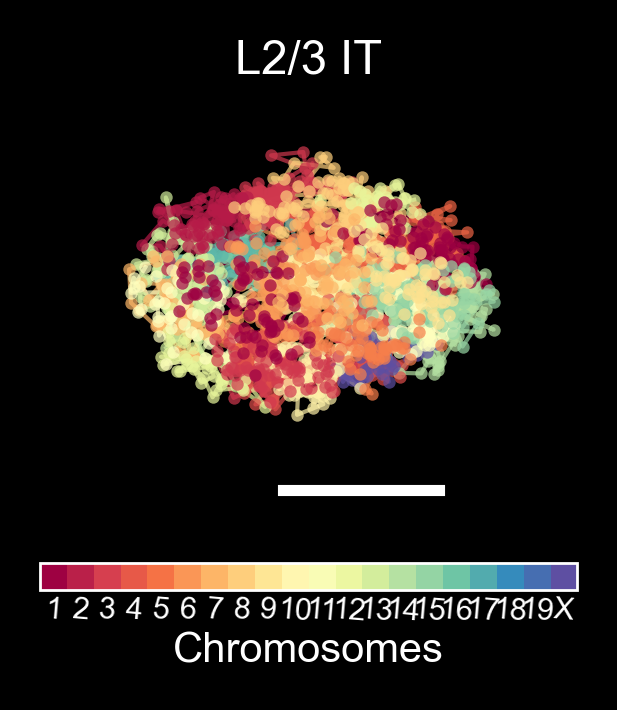

In [20]:
%matplotlib inline
#%matplotlib notebook
# select one cell from the candidate indices
_idx_to_plot = 10
_sel_cell_ind = sel_cell_indices[_idx_to_plot]
_dict = subclass_2_chr2ZxysList[sel_subclass][_sel_cell_ind]



from matplotlib.colors import BoundaryNorm
from matplotlib import animation
plot_animation = False
hide_axes = True
add_refBar = True
refBar_len = 5 # in um
angle = 3

_centered_dict = Centering_Chr2ZxysListDict(_dict)
_chr_2_color = {_key:genome_cmap((sort_chr(_key)-1)/22) for _key in sorted(_dict.keys(), key = lambda v:sort_chr(v))}

plot_radius = 4

marker_size = 5
marker_alpha = 0.7

depthshade=False
fig = plt.figure(figsize=(_page_width/3.5, _page_width/3.5), dpi=200)

ax3d = fig.add_subplot(111, projection='3d', azim=0, elev=30)
#ax3d.set_facecolor(background_color)
fig.subplots_adjust(left=0.05, right=0.95, bottom=0, top=0.9)
# turn off axes if needed
if hide_axes:
    ax3d.set_axis_off()
# turn off grid if needed
ax3d.grid(False)
ax3d.xaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
ax3d.yaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
ax3d.zaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
# scatter plot
for _chr in sorted(_centered_dict.keys(), key = lambda v:sort_chr(v)):
    _zxys_list = _centered_dict[_chr]
    for _zxys in _zxys_list:
        #print(_chr)
        _valid_inds = (np.isnan(_zxys).sum(1) == 0)
        _sc = ax3d.scatter(_zxys[_valid_inds,1], _zxys[_valid_inds,2], _zxys[_valid_inds,0],
                           color=_chr_2_color[_chr], 
                           s=marker_size, depthshade=depthshade, 
                           alpha=marker_alpha,
                           #edgecolors=_edge_colors, 
                           linewidth=0, label=f"{_chr}")
        _ln = ax3d.plot(_zxys[_valid_inds,1], _zxys[_valid_inds,2], _zxys[_valid_inds,0],
                        color=_chr_2_color[_chr], linewidth=0.75, alpha=marker_alpha)
ax3d.tick_params('both', labelsize=_font_size, 
                    width=0, length=0,
                    pad=0, labelleft=True, labelbottom=True) # remove bottom ticklabels for ax1
[i[1].set_linewidth(0.5) for i in ax3d.spines.items()]

# axes limits
ax3d.axes.set_xlim3d(left=-plot_radius, right=plot_radius) 
ax3d.axes.set_ylim3d(bottom=-plot_radius, top=plot_radius) 
ax3d.axes.set_zlim3d(bottom=-plot_radius, top=plot_radius) 
# axes ticks
ax3d.set_xticks(np.arange(-plot_radius,plot_radius+1, 2))
ax3d.set_yticks(np.arange(-plot_radius,plot_radius+1, 2))
ax3d.set_zticks(np.arange(-plot_radius,plot_radius+1, 2))
# axes labels
ax3d.set_xlabel(f"X (\u03BCm)", fontsize=_font_size, labelpad=0)
ax3d.set_ylabel(f"Y (\u03BCm)", fontsize=_font_size, labelpad=0)
ax3d.set_zlabel(f"Z (\u03BCm)", fontsize=_font_size, labelpad=0)
# title
ax3d.set_title(f"{sel_subclass}" ,fontsize=_font_size+1, pad=0)
# colorbar
bounds = [loci_1d_features.sort_mouse_chr(_chr) for _chr in _centered_dict.keys()]
bounds.append(np.max(bounds)+1)
bounds = np.sort(bounds)
norm = BoundaryNorm(bounds, genome_cmap.N)
cbar_shrink = 0.95
m = cm.ScalarMappable(cmap=genome_cmap, norm=norm)
cbar = plt.colorbar(m, ax=ax3d, orientation='horizontal', pad=0.1, 
                    ticks=bounds[:-1]+0.5,
                    boundaries=bounds,
                    shrink=cbar_shrink)
cbar.set_label('Chromosomes', fontsize=_font_size, labelpad=1,)
cbar.ax.set_xticklabels(np.array(sorted(_dict.keys(), key = lambda v:sort_chr(v))), fontsize=_font_size)

cbar.ax.tick_params('both', which='both',labelsize=_font_size-2, 
                    width=0.0, length=0.0,rotation =-5,
                    pad=1, labelleft=False, labelbottom=True) # remove bottom ticklabels for ax1
# vertical alignment of xtick labels
va = [-0.01 if i%2 else 0 for i in range(len(cbar.ax.get_xticklabels()))]
for t, y in zip(cbar.ax.get_xticklabels(), va):
    t.set_y(y)

[i[1].set_linewidth(0.5) for i in cbar.ax.spines.items()]



# save
fig_basename = f"decode3D_type_{sel_subclass.replace(' ', '_').replace(r'/', '-')}_cell_{_sel_cell_ind}"
# animation
if plot_animation:
    def rotate3D(angle):
         ax3d.view_init(azim=angle)
    ani = animation.FuncAnimation(fig, rotate3D, frames=np.arange(0, 360*2, angle), interval=50)
    ani.save(os.path.join(output_figure_folder, fig_basename+".gif"), 
             writer=animation.PillowWriter(fps=30), )
else:
    # add ref
    if add_refBar:
        # convert to degree, which matches numpy cos and sin
        _azim = (ax3d.azim%360) / 180 * np.pi 
        _elev = (ax3d.elev%360) / 180 * np.pi
        print(_azim, _elev)
        # start coordinate for colorbar
        _bar_starts = np.array([-2.5, # z, draw to the bottom
                                -np.sin(_azim), # x, y, extension goes through 0,0
                                np.cos(_azim), 
                                ]) * plot_radius
        # ongoing vector for colorbar:
        _bar_vector = np.array([0,
                                np.sin(_azim),
                                -np.cos(_azim),
                                ]) * refBar_len
        # therefore, end of colorbar
        _bar_ends = _bar_starts + _bar_vector
        #print(_bar_starts, _bar_ends)
        _ref_line = ax3d.plot([_bar_starts[1], _bar_ends[1]],
                              [_bar_starts[2], _bar_ends[2]], 
                              [_bar_starts[0], _bar_ends[0]], 
                              color=tuple([1-_c for _c in ax3d.get_facecolor()[:3]]+[1]), 
                              linewidth=2)

    # save pdf and png
    fig.savefig(os.path.join(output_figure_folder, fig_basename+".pdf"),
                transparent=False, bbox_inches='tight', pad_inches=.05, dpi=300)
    fig.savefig(os.path.join(output_figure_folder, fig_basename+".png"),
                transparent=False, bbox_inches='tight', pad_inches=.05, dpi=300)
fig.show()

### selected chromosomes

0.0 0.5235987755982988


C:\Users\shiwei\AppData\Local\Temp\3\ipykernel_46388\3503701947.py:149: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


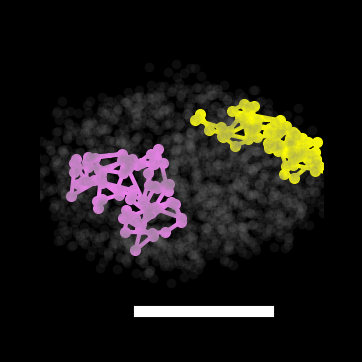

In [21]:
_sel_chr = '1'

if len(_dict[_sel_chr]) == 1:
    _homolog_2_color = {0:genome_cmap(1/2)}
else:
    #_homolog_2_color = {_i:genome_cmap((_i) / (len(_dict[_sel_chr])-1) ) 
                        #for _i in range(len(_dict[_sel_chr]))}
    _homolog_2_color = {0:'violet', 1:'yellow'}

    
from matplotlib.colors import BoundaryNorm
from matplotlib import animation
plot_animation = False
hide_axes = True
add_refBar = True
refBar_len = 5 # in um
angle = 3

add_cbar = False

_centered_dict = Centering_Chr2ZxysListDict(_dict)

plot_radius = 3.2

marker_size = 4
marker_alpha = 1

depthshade=False
fig = plt.figure(figsize=(_page_width/7, _page_width/7), dpi=200)

ax3d = fig.add_subplot(111, projection='3d', azim=0, elev=30)
#ax3d.set_facecolor(background_color)
fig.subplots_adjust(left=0.05, right=0.95, bottom=0, top=0.9)
# turn off axes if needed
if hide_axes:
    ax3d.set_axis_off()
# turn off grid if needed
ax3d.grid(False)
ax3d.xaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
ax3d.yaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
ax3d.zaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
# all spots as ref
merged_zxys, merged_rids = summarize_chr2Zxys(_centered_dict, codebook_df, keep_valid=True)
merged_zxys = merged_zxys
_valid_inds = (np.isnan(merged_zxys).sum(1) == 0)
_sc = ax3d.scatter(merged_zxys[_valid_inds,1], merged_zxys[_valid_inds,2], merged_zxys[_valid_inds,0],
                   color='Grey', 
                   s=marker_size-1, depthshade=depthshade, 
                   alpha=0.1,
                   linewidth=0, label=f"genome")

# scatter plot
_zxys_list = _centered_dict[_sel_chr]
for _ihomo, _zxys in enumerate(_zxys_list):
    #print(_chr)
    _valid_inds = (np.isnan(_zxys).sum(1) == 0)
    _sc = ax3d.scatter(_zxys[_valid_inds,1], _zxys[_valid_inds,2], _zxys[_valid_inds,0],
                       color=_homolog_2_color[_ihomo], 
                       s=marker_size, depthshade=depthshade, 
                       alpha=marker_alpha,
                       #edgecolors=_edge_colors, 
                       linewidth=0, label=f"h_{_ihomo}")
    _ln = ax3d.plot(_zxys[_valid_inds,1], _zxys[_valid_inds,2], _zxys[_valid_inds,0],
                    color=_homolog_2_color[_ihomo], linewidth=0.75, alpha=marker_alpha)

ax3d.tick_params('both', labelsize=_font_size-0.5, 
                    width=_ticklabel_width, length=_ticklabel_size,
                    pad=0, labelleft=True, labelbottom=True) # remove bottom ticklabels for ax1
[i[1].set_linewidth(0.5) for i in ax3d.spines.items()]

# axes limits
ax3d.axes.set_xlim3d(left=-plot_radius, right=plot_radius) 
ax3d.axes.set_ylim3d(bottom=-plot_radius, top=plot_radius) 
ax3d.axes.set_zlim3d(bottom=-plot_radius, top=plot_radius) 
# axes ticks
ax3d.set_xticks(np.arange(-plot_radius,plot_radius+1, 2))
ax3d.set_yticks(np.arange(-plot_radius,plot_radius+1, 2))
ax3d.set_zticks(np.arange(-plot_radius,plot_radius+1, 2))
# axes labels
ax3d.set_xlabel(f"X (\u03BCm)", fontsize=_font_size, labelpad=0)
ax3d.set_ylabel(f"Y (\u03BCm)", fontsize=_font_size, labelpad=0)
ax3d.set_zlabel(f"Z (\u03BCm)", fontsize=_font_size, labelpad=0)
# title
#ax3d.set_title(f"Chr{_sel_chr}" ,fontsize=_font_size+1, pad=0)

if add_cbar:
    # colorbar
    if len(_dict[_sel_chr]) == 1:
        bounds = [-1,0]
    else:
        bounds = list(np.arange(len(_dict[_sel_chr])+1 ))
    #bounds.append(np.max(bounds)+1)
    bounds = np.sort(bounds)
    norm = BoundaryNorm(bounds, genome_cmap.N)
    cbar_shrink = 0.8
    m = cm.ScalarMappable(cmap=genome_cmap, norm=norm)
    cbar = plt.colorbar(m, ax=ax3d, orientation='horizontal', pad=0.1, 
                        ticks=bounds[:-1]+0.5,
                        boundaries=bounds,
                        shrink=cbar_shrink)
    cbar.set_label('Homologs', fontsize=_font_size, labelpad=1,)
    cbar.ax.set_xticklabels(np.arange(len(_dict[_sel_chr])), fontsize=_font_size)
    cbar.ax.tick_params('both', labelsize=_font_size-2.5, 
                        width=_ticklabel_width, length=_ticklabel_size/2,
                        pad=1, labelleft=False, labelbottom=True) # remove bottom ticklabels for ax1
    [i[1].set_linewidth(0.5) for i in cbar.ax.spines.items()]

# save
fig_basename = f"decode3D_type_{sel_subclass.replace(' ', '_').replace(r'/', '-')}_cell_{_sel_cell_ind}_chr_{_sel_chr}"

# animation
if plot_animation:
    def rotate3D(angle):
         ax3d.view_init(azim=angle)
    ani = animation.FuncAnimation(fig, rotate3D, frames=np.arange(0, 360*2, angle), interval=50)
    ani.save(os.path.join(output_figure_folder, fig_basename+".gif"), 
             writer=animation.PillowWriter(fps=30), )
else:
    # add ref
    if add_refBar:
        # convert to degree, which matches numpy cos and sin
        _azim = (ax3d.azim%360) / 180 * np.pi 
        _elev = (ax3d.elev%360) / 180 * np.pi
        print(_azim, _elev)
        # start coordinate for colorbar
        _bar_starts = np.array([-2.5, # z, draw to the bottom
                                -np.sin(_azim), # x, y, extension goes through 0,0
                                np.cos(_azim), 
                                ]) * plot_radius
        # ongoing vector for colorbar:
        _bar_vector = np.array([0,
                                np.sin(_azim),
                                -np.cos(_azim),
                                ]) * refBar_len
        # therefore, end of colorbar
        _bar_ends = _bar_starts + _bar_vector
        #print(_bar_starts, _bar_ends)
        _ref_line = ax3d.plot([_bar_starts[1], _bar_ends[1]],
                              [_bar_starts[2], _bar_ends[2]], 
                              [_bar_starts[0], _bar_ends[0]], 
                              color=tuple([1-_c for _c in ax3d.get_facecolor()[:3]]+[1]), 
                              linewidth=2)

    # save pdf and png
    fig.savefig(os.path.join(output_figure_folder, fig_basename+".pdf"),
                transparent=False, bbox_inches='tight', pad_inches=0.05)
    fig.savefig(os.path.join(output_figure_folder, fig_basename+".png"),
                transparent=False, bbox_inches='tight', pad_inches=0.05)
fig.show()

0.0 0.5235987755982988


C:\Users\shiwei\AppData\Local\Temp\3\ipykernel_46388\3774079587.py:149: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


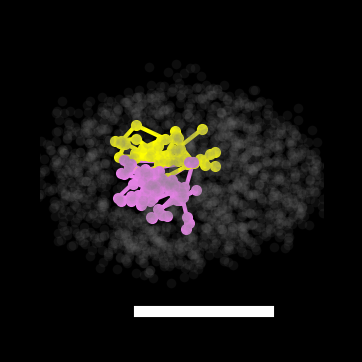

In [22]:
_sel_chr = '7'

if len(_dict[_sel_chr]) == 1:
    _homolog_2_color = {0:genome_cmap(1/2)}
else:
    #_homolog_2_color = {_i:genome_cmap((_i) / (len(_dict[_sel_chr])-1) ) 
                        #for _i in range(len(_dict[_sel_chr]))}
    _homolog_2_color = {0:'violet', 1:'yellow'}

    
from matplotlib.colors import BoundaryNorm
from matplotlib import animation
plot_animation = False
hide_axes = True
add_refBar = True
refBar_len = 5 # in um
angle = 3

add_cbar = False

_centered_dict = Centering_Chr2ZxysListDict(_dict)

plot_radius = 3.2

marker_size = 4
marker_alpha = 1

depthshade=False
fig = plt.figure(figsize=(_page_width/7, _page_width/7), dpi=200)

ax3d = fig.add_subplot(111, projection='3d', azim=0, elev=30)
#ax3d.set_facecolor(background_color)
fig.subplots_adjust(left=0.05, right=0.95, bottom=0, top=0.9)
# turn off axes if needed
if hide_axes:
    ax3d.set_axis_off()
# turn off grid if needed
ax3d.grid(False)
ax3d.xaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
ax3d.yaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
ax3d.zaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
# all spots as ref
merged_zxys, merged_rids = summarize_chr2Zxys(_centered_dict, codebook_df, keep_valid=True)
merged_zxys = merged_zxys
_valid_inds = (np.isnan(merged_zxys).sum(1) == 0)
_sc = ax3d.scatter(merged_zxys[_valid_inds,1], merged_zxys[_valid_inds,2], merged_zxys[_valid_inds,0],
                   color='Grey', 
                   s=marker_size-1, depthshade=depthshade, 
                   alpha=0.1,
                   linewidth=0, label=f"genome")

# scatter plot
_zxys_list = _centered_dict[_sel_chr]
for _ihomo, _zxys in enumerate(_zxys_list):
    #print(_chr)
    _valid_inds = (np.isnan(_zxys).sum(1) == 0)
    _sc = ax3d.scatter(_zxys[_valid_inds,1], _zxys[_valid_inds,2], _zxys[_valid_inds,0],
                       color=_homolog_2_color[_ihomo], 
                       s=marker_size, depthshade=depthshade, 
                       alpha=marker_alpha,
                       #edgecolors=_edge_colors, 
                       linewidth=0, label=f"h_{_ihomo}")
    _ln = ax3d.plot(_zxys[_valid_inds,1], _zxys[_valid_inds,2], _zxys[_valid_inds,0],
                    color=_homolog_2_color[_ihomo], linewidth=0.75, alpha=marker_alpha)

ax3d.tick_params('both', labelsize=_font_size-0.5, 
                    width=_ticklabel_width, length=_ticklabel_size,
                    pad=0, labelleft=True, labelbottom=True) # remove bottom ticklabels for ax1
[i[1].set_linewidth(0.5) for i in ax3d.spines.items()]

# axes limits
ax3d.axes.set_xlim3d(left=-plot_radius, right=plot_radius) 
ax3d.axes.set_ylim3d(bottom=-plot_radius, top=plot_radius) 
ax3d.axes.set_zlim3d(bottom=-plot_radius, top=plot_radius) 
# axes ticks
ax3d.set_xticks(np.arange(-plot_radius,plot_radius+1, 2))
ax3d.set_yticks(np.arange(-plot_radius,plot_radius+1, 2))
ax3d.set_zticks(np.arange(-plot_radius,plot_radius+1, 2))
# axes labels
ax3d.set_xlabel(f"X (\u03BCm)", fontsize=_font_size, labelpad=0)
ax3d.set_ylabel(f"Y (\u03BCm)", fontsize=_font_size, labelpad=0)
ax3d.set_zlabel(f"Z (\u03BCm)", fontsize=_font_size, labelpad=0)
# title
#ax3d.set_title(f"Chr{_sel_chr}" ,fontsize=_font_size+1, pad=0)

if add_cbar:
    # colorbar
    if len(_dict[_sel_chr]) == 1:
        bounds = [-1,0]
    else:
        bounds = list(np.arange(len(_dict[_sel_chr])+1 ))
    #bounds.append(np.max(bounds)+1)
    bounds = np.sort(bounds)
    norm = BoundaryNorm(bounds, genome_cmap.N)
    cbar_shrink = 0.8
    m = cm.ScalarMappable(cmap=genome_cmap, norm=norm)
    cbar = plt.colorbar(m, ax=ax3d, orientation='horizontal', pad=0.1, 
                        ticks=bounds[:-1]+0.5,
                        boundaries=bounds,
                        shrink=cbar_shrink)
    cbar.set_label('Homologs', fontsize=_font_size, labelpad=1,)
    cbar.ax.set_xticklabels(np.arange(len(_dict[_sel_chr])), fontsize=_font_size)
    cbar.ax.tick_params('both', labelsize=_font_size-2.5, 
                        width=_ticklabel_width, length=_ticklabel_size/2,
                        pad=1, labelleft=False, labelbottom=True) # remove bottom ticklabels for ax1
    [i[1].set_linewidth(0.5) for i in cbar.ax.spines.items()]

# save
fig_basename = f"decode3D_type_{sel_subclass.replace(' ', '_').replace(r'/', '-')}_cell_{_sel_cell_ind}_chr_{_sel_chr}"

# animation
if plot_animation:
    def rotate3D(angle):
         ax3d.view_init(azim=angle)
    ani = animation.FuncAnimation(fig, rotate3D, frames=np.arange(0, 360*2, angle), interval=50)
    ani.save(os.path.join(output_figure_folder, fig_basename+".gif"), 
             writer=animation.PillowWriter(fps=30), )
else:
    # add ref
    if add_refBar:
        # convert to degree, which matches numpy cos and sin
        _azim = (ax3d.azim%360) / 180 * np.pi 
        _elev = (ax3d.elev%360) / 180 * np.pi
        print(_azim, _elev)
        # start coordinate for colorbar
        _bar_starts = np.array([-2.5, # z, draw to the bottom
                                -np.sin(_azim), # x, y, extension goes through 0,0
                                np.cos(_azim), 
                                ]) * plot_radius
        # ongoing vector for colorbar:
        _bar_vector = np.array([0,
                                np.sin(_azim),
                                -np.cos(_azim),
                                ]) * refBar_len
        # therefore, end of colorbar
        _bar_ends = _bar_starts + _bar_vector
        #print(_bar_starts, _bar_ends)
        _ref_line = ax3d.plot([_bar_starts[1], _bar_ends[1]],
                              [_bar_starts[2], _bar_ends[2]], 
                              [_bar_starts[0], _bar_ends[0]], 
                              color=tuple([1-_c for _c in ax3d.get_facecolor()[:3]]+[1]), 
                              linewidth=2)

    # save pdf and png
    fig.savefig(os.path.join(output_figure_folder, fig_basename+".pdf"),
                transparent=False, bbox_inches='tight', pad_inches=0.05)
    fig.savefig(os.path.join(output_figure_folder, fig_basename+".png"),
                transparent=False, bbox_inches='tight', pad_inches=0.05)
fig.show()